## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from datetime import datetime, timedelta
from itertools import product

## Binary outcome & simulation: Arithmetic betting & risk-of-ruin

### Binary game simulation function

In [2]:
def getSim_binaryFixAmount(initAmount=100, a=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """
    Obtain dictionary of equal-amount-bet simulation results.
    initAmount: initial amount for betting
    f: percent per bet
    p: winning probability
    b: reward-to-risk ratio (/ odds)
    numTrialss: number of trials of the same binary game
    numSim: number of binary simulations
    """
    # Dict for recording different series of profit/loss
    simDict = {}
    # Dict for recording different series of capital (total equity)
    amountDict = {}
    # Generate a total of `numSim`= N series of binary game result and P/L
    stepFunc = lambda x: 1 if x > 0 else 0  # Lambda Function for getting "1" with a fixed prob and "0" otherwise
    for num in range(numSim):
        # Generate a series of "1"/"0" with probability p
        signArray = np.array([stepFunc(r) for r in np.random.uniform(p - 1, p, numTrials)])
        # Series of asset increment on win/loss result (EITHER increase by a * b OR decrease by a)
        trialArray = a * ((b + 1) * signArray - 1)
        # Record the asset increment series into `simDict`
        simDict[num + 1] = trialArray
        # Array of total equity and record into `amountDict`
        amountArray = initAmount + trialArray.cumsum()
        # IF equity drops below the fixed bet amount, stop betting
        period = 1
        while period <= numTrials - 1:
            if amountArray[period] < a:
                for j in range(period, numTrials):
                    amountArray[j] = amountArray[period]
                amountDict[f's{num}'] = amountArray
                break
            period += 1
        amountDict[f's{num + 1}'] = amountArray
    # Form dataframe from the `amountDict` and transpose, so that each row corresponds to a betting series
    dfSim = pd.DataFrame(amountDict).transpose()
    # Rename columns so that each number in column labels corresponds to the k-th trial
    dfSim = dfSim.rename(columns={k: (k + 1) for k in dfSim.columns})

    return dfSim

### Performance KPIs: winning rate, RRR (Realized reward-risk ratio), profit factor

In [3]:
def getProfitfactor(p, b):
    """Get profit factor of a binary game."""
    return round(p * b / (1 - p), 4)

def getOdds(p, pf):
    """Given fixed winning rate and profit factor, find odds (or reward-risk ratio)."""
    return pf * (1 - p) / p

def getWinrate(b, pf):
    """Given fixed odds and profit factor, find winning rate."""   
    return pf / (pf + b)

### Sample simulation: 20 trials, 30 simulations, converted into dataframe

In [4]:
initAmount0 = 100  # Initial capital
a0 = 20  # Fixed amount per bet
p0 = 0.5   # winning probability
b0 = 1.25   # reward-risk ratio / odds
numTrials0 = 10 # Number of trials
numSim0 = 20  # Number of simulations (how many people keep playing same game for 10 runs)

pf0 = round(getProfitfactor(p0, b0), 4)
print(f'Profit Factor = {pf0}')

dfSim0 = np.round(getSim_binaryFixAmount(initAmount0, a0, p0, b0, numTrials0, numSim0), 2)
dfSim0

Profit Factor = 1.25


,1,2,3,4,5,6,7,8,9,10
s1,125.0,150.0,130.0,155.0,180.0,160.0,185.0,210.0,190.0,215.0
s2,125.0,150.0,130.0,110.0,90.0,115.0,140.0,120.0,145.0,170.0
s3,80.0,60.0,85.0,110.0,135.0,115.0,95.0,120.0,100.0,125.0
s4,80.0,60.0,40.0,65.0,90.0,70.0,50.0,75.0,100.0,125.0
s5,80.0,105.0,130.0,155.0,180.0,160.0,140.0,165.0,190.0,170.0
s6,125.0,150.0,130.0,155.0,135.0,115.0,95.0,75.0,100.0,80.0
s7,80.0,105.0,130.0,110.0,135.0,115.0,140.0,120.0,100.0,80.0
s8,80.0,60.0,85.0,110.0,135.0,115.0,95.0,75.0,100.0,125.0
s9,125.0,150.0,130.0,110.0,90.0,70.0,95.0,75.0,100.0,125.0
s10,125.0,150.0,175.0,155.0,135.0,115.0,140.0,165.0,190.0,215.0


## Equity curve plotting

### Functions for simulation KPI & curve plotting

In [21]:
def getSimKPI_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400):
    """Obtain a dictionary of final performance KPI of simulations. """
    dfSim = simFunc(initAmount, f, p, b, numTrials, numSim)
    dictKPI = {}
    dictKPI['p'] = p
    dictKPI['b'] = b
    dictKPI['f'] = f
    dictKPI['profitfactor'] = round(getProfitfactor(p, b), 4)
    dictKPI['win%'] = round(100 * dfSim[dfSim[numTrials] >= initAmount].shape[0] / numSim, 2)
    dictKPI['avgAmount'] = round(dfSim[numTrials].mean(), 2)
    dictKPI['midAmount'] = round(dfSim[numTrials].median(), 2)
    dictKPI['stdAmount'] = round(dfSim[numTrials].std(), 2)

    return dfSim, dictKPI

def plotSim_discretePL(simFunc, initAmount=100, f=12.5, p=0.5, b=1.5, numTrials=50, numSim=400, semilog=True):
    """Plot equity curves from the betting simulations."""
    # Dataframe and KPI dict from `getSimKPI_discretePL()` function
    dfSim, dictKPI = getSimKPI_discretePL(simFunc, initAmount, f, p, b, numTrials, numSim)
    # First line of diagram title
    title = f'{numSim} simulations of {numTrials}-step binary game \n'
    if semilog:
        title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, {f}% per bet \n'
    else:
        title += f'Winning rate {round(p, 4)}, odds {round(b, 4)}, ${f} per bet \n'

    # Percentage of final equity above or equal to initial amount
    winrate = dictKPI['win%']
    avgAmount = dictKPI['avgAmount']  # Arithmetic mean of final equity
    midAmount = dictKPI['midAmount']  # Median of final equity
    stdAmount = dictKPI['stdAmount']  # SD of final equity
    profitfactor = dictKPI['profitfactor']

    # Attach key stats to title text
    title += f'Profit factor: {profitfactor}, final winrate: {winrate}% \n'
    title += f'Final equity mean: {avgAmount}, median: {midAmount}, SD: {stdAmount}'

    # Plot figure & append title
    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(title, fontsize=12)

    # Transpose the equity dataframe to plot
    dfPlot = dfSim.transpose()

    # Adopt semi-log scale for fixed-percent-betting & linear scale for fixed-amount-betting
    if semilog:
        plt.semilogy(dfPlot)
    plt.plot(dfPlot.index, np.repeat(initAmount, numTrials), color='black', linewidth=3, linestyle='dashed')
    plt.show()

### Standard sample: p = 0.4, b = 2.0

In [6]:
initAmount1 = 100  
a1 = 10  
p1 = 0.4   
b1 = 2.0   
numTrials1 = 50 
numSim1 = 1000  

dfSim1, dictKPI1 = getSimKPI_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, numTrials1, numSim1)
dictKPI1

{'p': 0.4,
 'b': 2.0,
 'f': 10,
 'profitfactor': 1.3333,
 'win%': 74.0,
 'avgAmount': 176.19,
 'midAmount': 200.0,
 'stdAmount': 116.57}

### Curves of 1000 simulations of 50 trials

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Columns: 1000 entries, s1 to s1000
dtypes: float64(1000)
memory usage: 393.5 KB
None


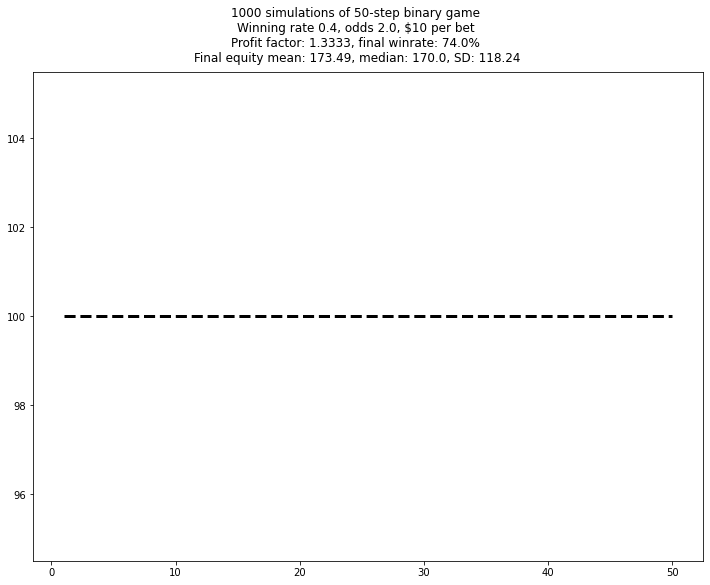

In [22]:
plotSim_discretePL(getSim_binaryFixAmount, initAmount1, a1, p1, b1, False, numTrials1, numSim1)

### Risk-of-ruin and 100 trials, 1000 simulations in sample case

In [ ]:
numtrials = 100
numsim = 1000
p = 0.5   # winning probability
b = 1.25   # reward-risk ratio / odds
perbet = 10

simdict1, amtdict1 = getsimarr(base, perbet, p=p, b=b, numtrials=numtrials, numsim=numsim)
dfbet1 = pd.DataFrame(amtdict1).transpose()

ruin = dfbet1[dfbet1[numtrials - 1] <= perbet].shape[0] / dfbet1.shape[0]
print(f"Risk of ruin with unit bet {perbet}, p=0.5, b={b}, {numtrials} bets: {ruin}")

### Final performance KPI of 1000 simulations of a binary game 

In [ ]:
def getsimkpi(base, perbet, p, b, numtrials, numsim):
    """Obtain a dictionary of final performance KPI of simulations. """
    simdict, amtdict = getsimarr(base, perbet, p, b, numtrials, numsim)
    dfbet = pd.DataFrame(amtdict).transpose()
    kpidict = dict()
    kpidict['ruin'] = round(dfbet[dfbet[numtrials - 1] <= perbet].shape[0] / dfbet.shape[0], 4)
    kpidict['win%'] = round(dfbet[dfbet[numtrials - 1] > base].shape[0] / dfbet.shape[0], 4)
    kpidict['P/Lavg'] = round(dfbet[numtrials - 1].mean() - base, 4)
    kpidict['P/Lstd'] = round(dfbet[numtrials - 1].std(), 4) 
    
    return dfbet, kpidict

In [ ]:
dfbettest, kpidicttest = getsimkpi(100, 20, 0.5, 1.25, 104, 1000)
kpidicttest

In [ ]:
dfbettest, kpidicttest = getsimkpi(100, 10, 0.56, 1.44, 104, 1000)
kpidicttest

## Fixed p = 0.5, 104 bets (2 year), 1000 sims, varied perbet amount and odds

### Simulations

In [ ]:
oddslist = [0.25 * r for r in range(2, 13)]
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]
base = 100
p = 0.5
numtrials = 104
numsim = 1000

betdict = dict()
dfruin1 = pd.DataFrame(columns=oddslist, index=dollist)  # Risk of ruin
dfplus1 = pd.DataFrame(columns=oddslist, index=dollist)  # Terminal winning probability
dfamtavg1 = pd.DataFrame(columns=oddslist, index=dollist) # Average final P/L
dfamtstd1 = pd.DataFrame(columns=oddslist, index=dollist) # SD of final P/L
for odds, amt in product(oddslist, amtlist):
    dfbet, kpidict = getsimkpi(base, amt, p, odds, numtrials, numsim)
    betdict[(p, odds, amt)] = dfbet
    dfruin1.loc[f'${amt}', odds] = kpidict['ruin']
    dfplus1.loc[f'${amt}', odds] = kpidict['win%']
    dfamtavg1.loc[f'${amt}', odds] = kpidict['P/Lavg']
    dfamtstd1.loc[f'${amt}', odds] = kpidict['P/Lstd'] 

### Equity Curve plots: Profit factor 1.5, 10 per bet

In [ ]:
fig = plt.figure(figsize=(12, 9))
spec = (0.5, 1.25, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 9))
spec = (0.5, 2.0, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

### Equity Curve plots: Profit factor 0.75, 10 per bet

In [ ]:
fig = plt.figure(figsize=(12, 9))
spec = (0.5, 0.75, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

### Risk-of-ruin

In [ ]:
dfruin1

In [ ]:
dfruin1[(dfruin1 <= 0.01) & (dfamtavg1 > 0)]

### Probability of terminal winning 

In [ ]:
dfplus1

In [ ]:
dfplus1[(dfruin1 <= 0.01) & (dfamtavg1 > 0)]

### Average Terminal P/L

In [ ]:
dfamtavg1[(dfruin1 <= 0.01) & (dfamtavg1 > 0)]

### SD of  Terminal P/L (positive skew due to extreme winners)

In [ ]:
dfamtstd1

## Fixed odds = 1, 104 bets (2 year), 1000 sims, varied perbet amount and odds

### Simulations

In [ ]:
base = 100
odds = 1
problist = [pf / (pf + odds) for pf in np.arange(0.5, 3.25, 0.25)]
probcollist = [f'{round(100 * prob, 1)}%' for prob in problist]
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]
numtrials = 104
numsim = 1000

dfruin2 = pd.DataFrame(columns=probcollist, index=dollist)  # Risk of ruin
dfplus2 = pd.DataFrame(columns=probcollist, index=dollist)  # Terminal winning probability
dfamtavg2 = pd.DataFrame(columns=probcollist, index=dollist) # Average final P/L
dfamtstd2 = pd.DataFrame(columns=probcollist, index=dollist) # SD of final P/L

for p, amt in product(problist, amtlist):
    prob = round(100 * p, 1)
    dfbet, kpidict = getsimkpi(base, amt, p, odds, numtrials, numsim)
    betdict[(p, odds, amt)] = dfbet
    dfruin2.loc[f'${amt}', f'{prob}%'] = kpidict['ruin']
    dfplus2.loc[f'${amt}', f'{prob}%'] = kpidict['win%']
    dfamtavg2.loc[f'${amt}', f'{prob}%'] = kpidict['P/Lavg']
    dfamtstd2.loc[f'${amt}', f'{prob}%'] = kpidict['P/Lstd']


### Equity curve Plots (profit factor 2.0, 10 per bet)

In [ ]:
fig = plt.figure(figsize=(12, 9))
spec = (0.6, 1, 10)

fig.suptitle(f'1000 Simulations with prob {spec[0]}, odds {spec[1]}, ${spec[2]} per bet')
plt.plot(betdict[spec].transpose())
plt.show()

### Risk-of-ruin

In [ ]:
dfruin2

In [ ]:
dfruin2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

### Probability of terminal winning 

In [ ]:
dfplus2

In [ ]:
dfplus2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

### Average Terminal P/L

In [ ]:
dfamtavg2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

### SD Terminal P/L

In [ ]:
dfamtstd2[(dfruin2 < 0.01) & (dfamtavg2 > 0)]

## Fixed Profit Factor = 1.5, 104 bets, varied prob & per bet 

In [ ]:
oddslist = [0.25 * r for r in range(2, 13)]
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]

base = 100
numtrials = 104
numsim = 1000
pfactor = 1.5

dfruin3 = pd.DataFrame(columns=oddslist, index=dollist)
dfplus3 = pd.DataFrame(columns=oddslist, index=dollist)
dfamtavg3 = pd.DataFrame(columns=oddslist, index=dollist)
dfamtstd3 = pd.DataFrame(columns=oddslist, index=dollist)


for odds, amt in product(oddslist, amtlist):
    p = pfactor / (odds + pfactor)
    dfbet, kpidict = getsimkpi(base, amt, p, odds, numtrials, numsim)
    betdict[(p, odds, amt)] = dfbet
    dfruin3.loc[f'${amt}', odds] = kpidict['ruin']
    dfplus3.loc[f'${amt}', odds] = kpidict['win%']  
    dfamtavg3.loc[f'${amt}', odds] = kpidict['P/Lavg'] 
    dfamtstd3.loc[f'${amt}', odds] = kpidict['P/Lstd'] 

### Risk-of-ruin

In [ ]:
dfruin3

In [ ]:
dfruin3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

### Terminal winning probabilities

In [ ]:
dfplus3

### Average Terminal P/L

In [ ]:
dfamtavg3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

### SD Terminal P/L

In [ ]:
dfamtstd3[(dfruin3 < 0.01) & (dfamtavg3 > 0)]

## Fixed winrate p and odds b, varied number of trials & bet amount

In [ ]:
numsim = 1000
base = 100
p = 0.54
b = 1.56
pfactor = b*p / (1 - p)
print(f'Profit Factor = {pfactor}')
triallist = list(range(50, 300, 50))
amtlist = [25, 20, 12.5, 10, 8, 5, 4, 3, 2, 1]
dollist = [f'${amt}' for amt in amtlist]

dfruin4 = pd.DataFrame(columns=triallist, index=dollist)
dfplus4 = pd.DataFrame(columns=triallist, index=dollist)
dfamtavg4 = pd.DataFrame(columns=triallist, index=dollist)
dfamtstd4 = pd.DataFrame(columns=triallist, index=dollist)

for numtrial, amt in product(triallist, amtlist):
    dfbet, kpidict = getsimkpi(base, amt, p, b, numtrial, numsim)
    dfruin4.loc[f'${amt}', numtrial] = kpidict['ruin']
    dfplus4.loc[f'${amt}', numtrial] = kpidict['win%']  
    dfamtavg4.loc[f'${amt}', numtrial] = kpidict['P/Lavg'] 
    dfamtstd4.loc[f'${amt}', numtrial] = kpidict['P/Lstd'] 

### Risk-of-ruin

In [ ]:
dfruin4

### Terminal winning probabilities

In [ ]:
dfplus4[dfruin4 < 0.01]

### Average Terminal P/L

In [ ]:
dfamtavg4[(dfruin4 < 0.01)]